In [21]:
import os
import pandas as pd
from io import BytesIO
import numpy as np
from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [4]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/samarthgoal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/samarthgoal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# ! deprecated
# https://github.com/christiansafka/img2vec
# dependenceis : 
# Pytorch: http://pytorch.org/
# Pillow: pip install Pillow

# from img_to_vec import Img2Vec
# img2vec = Img2Vec()

In [44]:
## trying with img1
# @ param: img url @ return vector 
from PIL import Image
import requests
def get_img_vector(url):
    try :
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if (response.status_code == 200):
            try:
                if (url.endswith('.jpg') or url.endswith('.jpeg')):
                    vec = img2vec.get_vec(img,model='alexnet')
                elif (url.endswith('.png')):
                    rgb_img = img.convert('RGB')
                    vec = img2vec.get_vec(rgb_img)
                else:
                    vec = np.zeros(512)
            except RuntimeError as e:
                vec = np.zeros(512)     # except runtime error fro file that doesn't exits
        else:
            vec = np.zeros(512)
        return vec
    except ConnectionError as e:
        vec = np.zeros(512)
        return vec
    except:
        vec = np.zeros(512)  
        return vec

In [12]:
dir_path = "/home/samarthgoal/language_vision/input/reddit"

In [13]:
## files in the reddit_data
os.listdir(dir_path)

['processed_gore.csv',
 'processed_creepy.csv',
 'processed_happy.csv',
 'processed_rage.csv']

## cheking image vectors

In [14]:
from PIL import Image
image_url = df_rage.loc[6]["url"]
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))    

NameError: name 'df_rage' is not defined

#### using alex net pre trained architecture

In [28]:
# works only for JPG file but not for PNG types..?(need to convert png to jpg before passing) 
# and doesnt work for http://imgur.com/uNtwClS files :(OSError: cannot identify image file <_io.BytesIO object at 0x1274c1a98>)
type(img)
vec = img2vec.get_vec(img)


In [29]:
vec1 = get_img_vector(df_rage.loc[1]["url"]) 
vec2 = get_img_vector(df_rage.loc[2]["url"])
vec3 = get_img_vector(df_rage.loc[4]["url"])
vec4 = get_img_vector(df_rage.loc[6]["url"])

In [262]:
len(vec1)

512

In [30]:
labels = ["car","woman","girl","mother"]

In [31]:
vec = [vec1] + [vec2] + [vec3] + [vec4]

In [32]:
X_embedded = TSNE(n_components=2).fit_transform(vec)

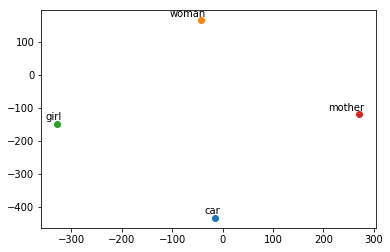

In [33]:
x= []
y =[]
for value in X_embedded:
    x.append(value[0])
    y.append(value[1])
    
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

## looking at sentence vectors

from glove import Corpus, Glove

In [24]:
## getting the glove embeddings
from tqdm import tqdm
# the object is a word2vec dictionary with value as array vector,
# creates a mean of word vecotr for sentences
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
        
    # pass a word list
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in (X)
        ])

In [25]:
## lstm , check papers () for the models

In [26]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [27]:
## tokenize the text..
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

## preprocessing data

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [16]:
df_rage = pd.read_csv(os.path.join(dir_path,'processed_rage.csv'))
df_happy =  pd.read_csv(os.path.join(dir_path,'processed_happy.csv'))
df_gore =  pd.read_csv(os.path.join(dir_path,'processed_gore.csv'))
df_creepy =  pd.read_csv(os.path.join(dir_path,'processed_creepy.csv'))

In [17]:
# create a random balances dataset of all of the categories
length = np.min([len(df_rage),len(df_happy),len(df_creepy),len(df_gore)])

In [18]:
Y = [1 for i in range(length)]        # rage 1
Y.extend([2 for i in range(length)])  # happiness 2
Y.extend([3 for i in range(length)])  # gore 3
Y.extend([4 for i in range(length)])  # creepy 4
y = np.array(Y)

In [19]:
df_final = pd.concat([df_rage[:length], df_happy[:length], df_gore[:length], df_creepy[:length]], ignore_index=True)

In [29]:
%time
tqdm.pandas()
token_list = (df_final['title'].apply(get_tokens))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [30]:
Y_new = df_final['subreddit']

In [31]:
Y_new = le.fit_transform(Y_new) 

#### Average word vectors

In [37]:
# use the glove embeddings to replace ..
# embedding_path = "/Users/akshayuppal/Desktop/launguage_vision/project/embeddings/glove/glove.6B.100d.txt"
## trying twitter embeddings now
embedding_path = "/home/samarthgoal/embeddings/glove.twitter.27B.200d.txt"

In [ ]:
word2vec = get_word2vec(embedding_path)

In [ ]:
# word2vec = pickle.load(open(os.path.join("models","w2v.pkl"),"rb"))

In [ ]:
ob = MeanEmbeddingVectorizer(word2vec)

In [ ]:
# vectorize sentences of the emotional data <language modality>
X= ob.transform(token_list)

In [ ]:
# shuffle the data
from sklearn.utils import shuffle
X,y = shuffle(X,Y_new,random_state=3)

In [ ]:
## now splitting into test and training data
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test =  train_test_split(X, y,test_size =0.20,random_state= 4 )

## classifier


In [147]:
# @retruns a svm fit model on data
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [140]:
def svm_wrapper(X_train,Y_train):
    param_grid = [
    {'C': [1, 10], 'kernel': ['linear']},
    {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']},]
    svm = GridSearchCV(SVC(),param_grid)
    svm.fit(X_train, Y_train)
    return(svm)

In [141]:
from sklearn.ensemble import RandomForestClassifier
def radom_forest_wrapper(X_train,Y_train):
    param_grid = [
    { 'max_depth' : [i for i in np.arange(1,10)], 
       'n_estimators': [j for j in np.arange(1,10)]}]
    rand = GridSearchCV(RandomForestClassifier(),param_grid)
    rand.fit(X_train,Y_train)
    return(rand)

In [142]:
from sklearn.naive_bayes import BernoulliNB
def naive_bayes(X_train,Y_train):
    clf = BernoulliNB()
    clf.fit(X_train, Y_train)
    return(clf)

In [143]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
def PCA_with_SVM(X_train,Y_train):
    estimators = [('reduce_dim', PCA()), ('clf', SVC() )]
    pipe = Pipeline(estimators)
    pipe.fit(X_train,Y_train)
    return(pipe)

In [144]:
def boosting(X_train,Y_train):
    gb= GradientBoostingClassifier()
    gb.fit(X_train, Y_train)
    return(gb)


In [145]:
from sklearn.neural_network import MLPClassifier
def mlp_wrapper(X_train,Y_train):
    param_grid = [{'hidden_layer_sizes':np.arange(10,100,4),'max_iter':[30] ,'activation':['logistic', 'tanh','relu']}]
    mlp = GridSearchCV(MLPClassifier(), param_grid)
    mlp.fit(X_train, Y_train)
    return(mlp)

In [ ]:
# random forest
rand = radom_forest_wrapper(X_train,Y_train)
Y_pred = rand.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

In [ ]:
# naive bayes
nb = naive_bayes(X_train,Y_train)
Y_pred = nb.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

In [ ]:
# pca with svm
psvm = PCA_with_SVM(X_train,Y_train)
Y_pred = psvm.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

In [ ]:
# boosting
bs = boosting(X_train,Y_train)
Y_pred = bs.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

In [252]:
# mlp
ml = mlp_wrapper(X_train,Y_train)
Y_pred = ml.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum it

accuarcy : 0.6910569105691057
  Classification Report:
              precision    recall  f1-score   support

          0       0.59      0.68      0.63       119
          1       0.70      0.63      0.66       124
          2       0.80      0.83      0.82       121
          3       0.68      0.62      0.65       128

avg / total       0.69      0.69      0.69       492
 



/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# svm
svm = svm_wrapper(X_train,Y_train)
Y_pred = svm.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

# image modalities

In [1]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import 
from keras.applications.inception_v3 import 
import numpy as np

Using TensorFlow backend.


In [2]:
import os
import pandas as pd
from io import BytesIO
import numpy as np
from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from keras.layers import Lambda, Input
from keras.models import Model
from keras.backend import tf as ktf
import urllib.request
tqdm.pandas()

In [3]:
dir_path = "/home/samarthgoal/language_vision/input/reddit"

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [5]:
df_rage = pd.read_csv(os.path.join(dir_path,'processed_rage.csv'))
df_happy =  pd.read_csv(os.path.join(dir_path,'processed_happy.csv'))
df_gore =  pd.read_csv(os.path.join(dir_path,'processed_gore.csv'))
df_creepy =  pd.read_csv(os.path.join(dir_path,'processed_creepy.csv'))

In [6]:
# create a random balances dataset of all of the categories
length = np.min([len(df_rage),len(df_happy),len(df_creepy),len(df_gore)])

In [7]:
Y = [1 for i in range(length)]        # rage 1
Y.extend([2 for i in range(length)])  # happiness 2
Y.extend([3 for i in range(length)])  # gore 3
Y.extend([4 for i in range(length)])  # creepy 4
y = np.array(Y)

In [8]:
df_final = pd.concat([df_rage[:length], df_happy[:length], df_gore[:length], df_creepy[:length]], ignore_index=True)

In [9]:
Y_new = df_final['subreddit']

In [10]:
Y_new = le.fit_transform(Y_new) 

In [11]:
from sklearn.utils import shuffle
df_img,y = shuffle(df_final,Y_new,random_state=3)

In [12]:
df_img.reset_index(inplace=True)

In [120]:
URL = list(df_img['url'])[336]
# response = requests.get(url)
with urllib.request.urlopen(URL) as url:
    with open('temp.jpg', 'wb') as f:
        f.write(url.read())
img = image.load_img('temp.jpg', target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)
vec1 = model.predict(img_data)
vec = vec1.flatten()
vec1.shape

(1, 7, 7, 512)

### vg16 model

In [195]:
## trying with img1
# @ param: img url @ return feature vector 
from PIL import Image
import requests
model = VGG16(weights='imagenet', include_top=False)
def get_img_vector(url):
    try : 
        response = requests.get(url)
        if (response.status_code == 200):
            try:
                if (url.endswith('.jpg') or url.endswith('.jpeg') or url.endswith('.png')):
                    with urllib.request.urlopen(url) as url1:
                        with open('temp.jpg', 'wb') as f:
                            f.write(url1.read())
                        f.close()
                    img = image.load_img('temp.jpg', target_size=(224, 224))
                    os.remove('temp.jpg')
                    img_data = image.img_to_array(img)
                    img_data = np.expand_dims(img_data, axis=0)
                    img_data = preprocess_input(img_data)
                    vec1 = model.predict(img_data)
                    vec = list(vec1.flatten())
                else:
                    vec = list(np.zeros(224*112))
            except RuntimeError as e:
                vec = list(np.zeros(224*112))  # except runtime error fro file that doesn't exits
        else:
            vec = list(np.zeros(224*112))
        return vec
    except ConnectionError as e:
        vec = list(np.zeros(224*112))
        return vec
    except:
        vec = list(np.zeros(224*112))
        return vec

In [35]:
## get the vector from the model
def get_vector(img_data,model):
    if (img_data):
        vec = model.predict(img_data)
        vec = vec.flatten()
    else:
        vec = np.zeros(224*112)
    return (vec)

In [ ]:
## takes a lot of time
img_data = df_img['url'][:100].progress_apply(get_img_vector)

 41%|████      | 41/100 [00:37<00:54,  1.09it/s]

In [226]:
## flatttened from (1, 224, 224, 3) :-> (25088,)
vec_input = np.array(list(img_data))
## check with inception net, resnet architecture as well

In [227]:
# no of zero images..
indices = ([idx for idx,element in enumerate(vec_input) if not np.any(element)])
print(len(indices))
## 

3


In [ ]:
X_input = vec_input
y= y[:100]

In [ ]:
## now splitting into test and training data
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test =  train_test_split(X_input, y,test_size =0.20,random_state= 4 )

In [ ]:
# svm
svm = svm_wrapper(X_train,Y_train)
Y_pred = svm.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

## with pre-trained alexnet architecture

In [21]:
## using the pretrained architecture: alexnet and imagenet using keras

In [ ]:
## VG16


In [391]:
# random forest
rand = radom_forest_wrapper(X_train,Y_train)
Y_pred = rand.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.2804878048780488
  Classification Report:
              precision    recall  f1-score   support

          0       0.25      0.97      0.40       119
          1       1.00      0.01      0.02       124
          2       0.25      0.01      0.02       121
          3       0.75      0.16      0.27       128

avg / total       0.57      0.28      0.17       492
 



In [392]:
# naive bayes
nb = naive_bayes(X_train,Y_train)
Y_pred = nb.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.2926829268292683
  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       119
          1       0.26      0.97      0.41       124
          2       0.00      0.00      0.00       121
          3       0.67      0.19      0.29       128

avg / total       0.24      0.29      0.18       492
 



/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [384]:
ml = mlp_wrapper(X_train,Y_train)
Y_pred = ml.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum it

accuarcy : 0.5670731707317073
  Classification Report:
              precision    recall  f1-score   support

          0       0.39      0.87      0.54       119
          1       0.87      0.44      0.59       124
          2       0.68      0.43      0.53       121
          3       0.76      0.54      0.63       128

avg / total       0.68      0.57      0.57       492
 



/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [393]:
# svm
svm = svm_wrapper(X_train,Y_train)
Y_pred = svm.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.29878048780487804
  Classification Report:
              precision    recall  f1-score   support

          0       0.50      0.02      0.03       119
          1       0.27      0.99      0.42       124
          2       0.25      0.01      0.02       121
          3       0.84      0.16      0.27       128

avg / total       0.47      0.30      0.19       492
 



In [394]:
# pca with svm
psvm = PCA_with_SVM(X_train,Y_train)
Y_pred = psvm.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.2886178861788618
  Classification Report:
              precision    recall  f1-score   support

          0       0.25      0.97      0.40       119
          1       1.00      0.02      0.05       124
          2       0.00      0.00      0.00       121
          3       0.85      0.18      0.30       128

avg / total       0.53      0.29      0.19       492
 



## With pre-trained resnet

In [377]:
# random forest
rand = radom_forest_wrapper(X_train,Y_train)
Y_pred = rand.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.483739837398374
  Classification Report:
              precision    recall  f1-score   support

          0       0.36      0.78      0.49       119
          1       0.66      0.39      0.49       124
          2       0.54      0.27      0.36       121
          3       0.65      0.50      0.57       128

avg / total       0.56      0.48      0.48       492
 



In [376]:
# naive bayes
nb = naive_bayes(X_train,Y_train)
Y_pred = nb.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.30284552845528456
  Classification Report:
              precision    recall  f1-score   support

          0       0.28      0.45      0.35       119
          1       0.00      0.00      0.00       124
          2       0.00      0.00      0.00       121
          3       0.32      0.74      0.44       128

avg / total       0.15      0.30      0.20       492
 



/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [384]:
ml = mlp_wrapper(X_train,Y_train)
Y_pred = ml.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum it

accuarcy : 0.5670731707317073
  Classification Report:
              precision    recall  f1-score   support

          0       0.39      0.87      0.54       119
          1       0.87      0.44      0.59       124
          2       0.68      0.43      0.53       121
          3       0.76      0.54      0.63       128

avg / total       0.68      0.57      0.57       492
 



/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [368]:
# svm
svm = svm_wrapper(X_train,Y_train)
Y_pred = svm.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.5487804878048781
  Classification Report:
              precision    recall  f1-score   support

          0       0.38      0.90      0.54       119
          1       0.98      0.38      0.55       124
          2       0.76      0.31      0.44       121
          3       0.68      0.61      0.64       128

avg / total       0.70      0.55      0.54       492
 



In [378]:
# pca with svm
psvm = PCA_with_SVM(X_train,Y_train)
Y_pred = psvm.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("accuarcy :", score)
confusion_matrix(Y_test,Y_pred)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

accuarcy : 0.5813008130081301
  Classification Report:
              precision    recall  f1-score   support

          0       0.41      0.90      0.56       119
          1       0.89      0.44      0.59       124
          2       0.74      0.41      0.53       121
          3       0.76      0.58      0.65       128

avg / total       0.70      0.58      0.58       492
 



## testing

In [39]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(embedding_path, "r")
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [34]:
#dump the word2vec
import pickle
with open(os.path.join("models","w2v.pkl"),"wb") as f:
    pickle.dump(word2vec,f)

## checking word tokenizer vs twitter tokenizer

In [97]:
s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"

In [96]:
s1 = list(df_final.head(1)['title'])[0]
s1

'r/gore. Not r/shatter.'

In [99]:
np.array(nltk.word_tokenize(s0))

array(['This', 'is', 'a', 'cooool', '#', 'dummysmiley', ':', ':', '-',
       ')', ':', '-P', '<', '3', 'and', 'some', 'arrows', '<', '>', '-',
       '>', '<', '--'], dtype='<U11')

In [92]:
nltk.word_tokenize(sentence)

['r/gore', '.', 'Not', 'r/shatter', '.']

In [103]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
np.array(tknzr.tokenize(s0))

array(['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P',
       '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--'], dtype='<U12')

In [104]:
np.array(tknzr.tokenize(s1))

array(['r', '/', 'gore', '.', 'Not', 'r', '/', 'shatter', '.'],
      dtype='<U7')

In [105]:
## tweet tokenizer seems to be doing a good job in sentences containing special character (#,/,etc) and emoticons..
## as the data is reddit post is somewhat simialr to tweets 